In [1]:
import io
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from qiskit import QuantumCircuit

from constants import ALL_FILES, LABELS, TARGET_ASSETS_FOLDER
from quantum_utils import player1, player2, player3, player4, dealer, gun, player_play, dealer_play

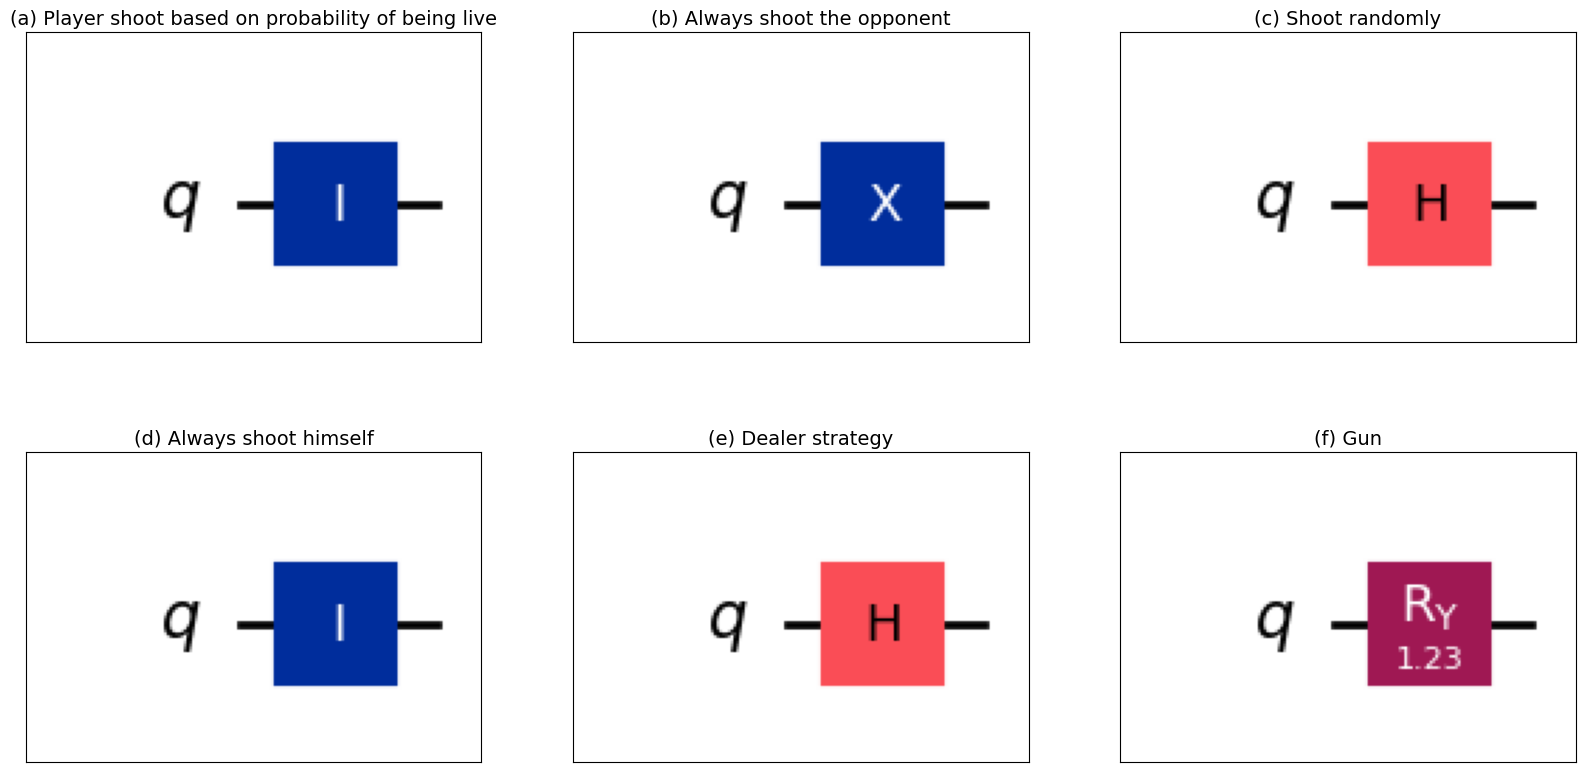

In [2]:
rows = 2
cols = 3

objs = (player1, player2, player3, player4, dealer,gun)
names = ('(a) Player shoot based on probability of being live', '(b) Always shoot the opponent', '(c) Shoot randomly', '(d) Always shoot himself', '(e) Dealer strategy', '(f) Gun')
current = 0
sns.reset_defaults()
fig, ax = plt.subplots(rows,cols, figsize=(20,10))

for i in range(rows):
    for j in range(cols):
        ax[i,j].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        ax[i,j].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)


        ax[i,j].set_title(names[current], fontsize=14)

        qc = QuantumCircuit(1)
        strategy = objs[current]
        op = strategy(3,1)
        op.label = None
        qc.append(op, [0])
        circuit = qc.draw('mpl')

        buf = io.BytesIO()
        circuit.savefig(buf, format='png', bbox_inches='tight')
        buf.seek(0)

        img = Image.open(buf)

        ax[i,j].imshow(img)

        current += 1

fig.savefig(os.path.join(TARGET_ASSETS_FOLDER, 'quantum-strategies.png'), bbox_inches="tight")
plt.show()


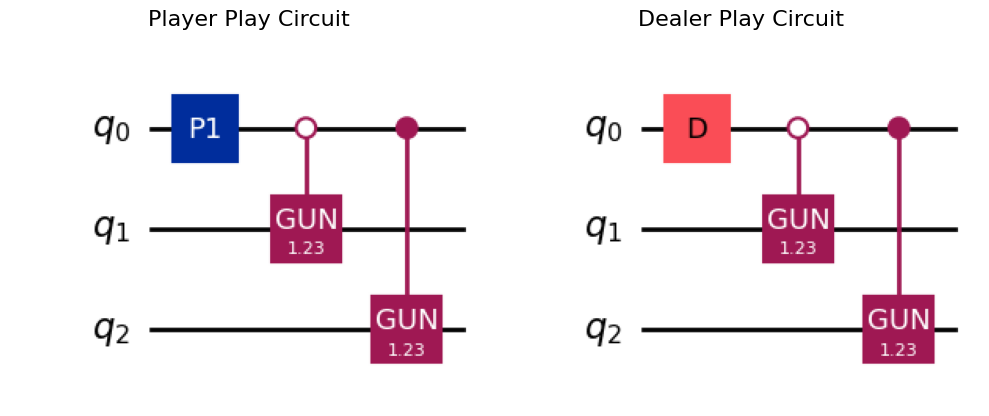

In [3]:
plots = 2
plays = (player_play(player1, 3, 1, name=""), dealer_play(dealer, 3, 1, name=""))
names = ("Player Play Circuit", "Dealer Play Circuit")

fig,ax = plt.subplots(1,plots,figsize=(10,5))

for i in range(plots):
    circuit = plays[i].draw('mpl')
    buf = io.BytesIO()
    circuit.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)

    img = Image.open(buf)

    ax[i].set_title(names[i], fontsize=16)

    ax[i].imshow(img)
    ax[i].axis('off')

fig.tight_layout()
fig.savefig(os.path.join(TARGET_ASSETS_FOLDER, 'quantum-plays.png'), bbox_inches="tight")
plt.show()

In [4]:
data = pd.DataFrame(columns=("winner", "label", "strategy", "rounds"))
labels = LABELS
datasets = ALL_FILES

print("---Classical---")
for label,dataset in zip(labels[:4],datasets[:4]):
    print(f"getting {label} from {dataset}")
    d = pd.read_csv(os.path.join(TARGET_ASSETS_FOLDER, dataset))
    grouped_data = d.groupby(["eval_i", "strategy", "rounds","winner"]).size().reset_index(name="total")
    grouped_data.drop("eval_i", axis=1)
    grouped_data["label"] = label
    data = pd.concat([data,grouped_data], ignore_index=True)

print("---Quantum---")
for label,dataset in zip(labels[4:],datasets[4:]):
    print(f"getting {label} from {dataset}")
    q = pd.read_csv(os.path.join(TARGET_ASSETS_FOLDER, dataset))
    q.drop("eval_i", axis=1)
    q["label"] = label
    data = pd.concat([data,q], ignore_index=True)

---Classical---
getting classical-random from classical-results-no-seed.csv
getting classical-random-seed from classical-results-with-seed.csv
getting cpp-random-seed from classical-results-cpp-random-seed.csv
getting cpp from classical-results-cpp-with-seed.csv
---Quantum---
getting quantum-regular from quantum-results-regular.csv
getting quantum-modified from quantum-results-modified.csv


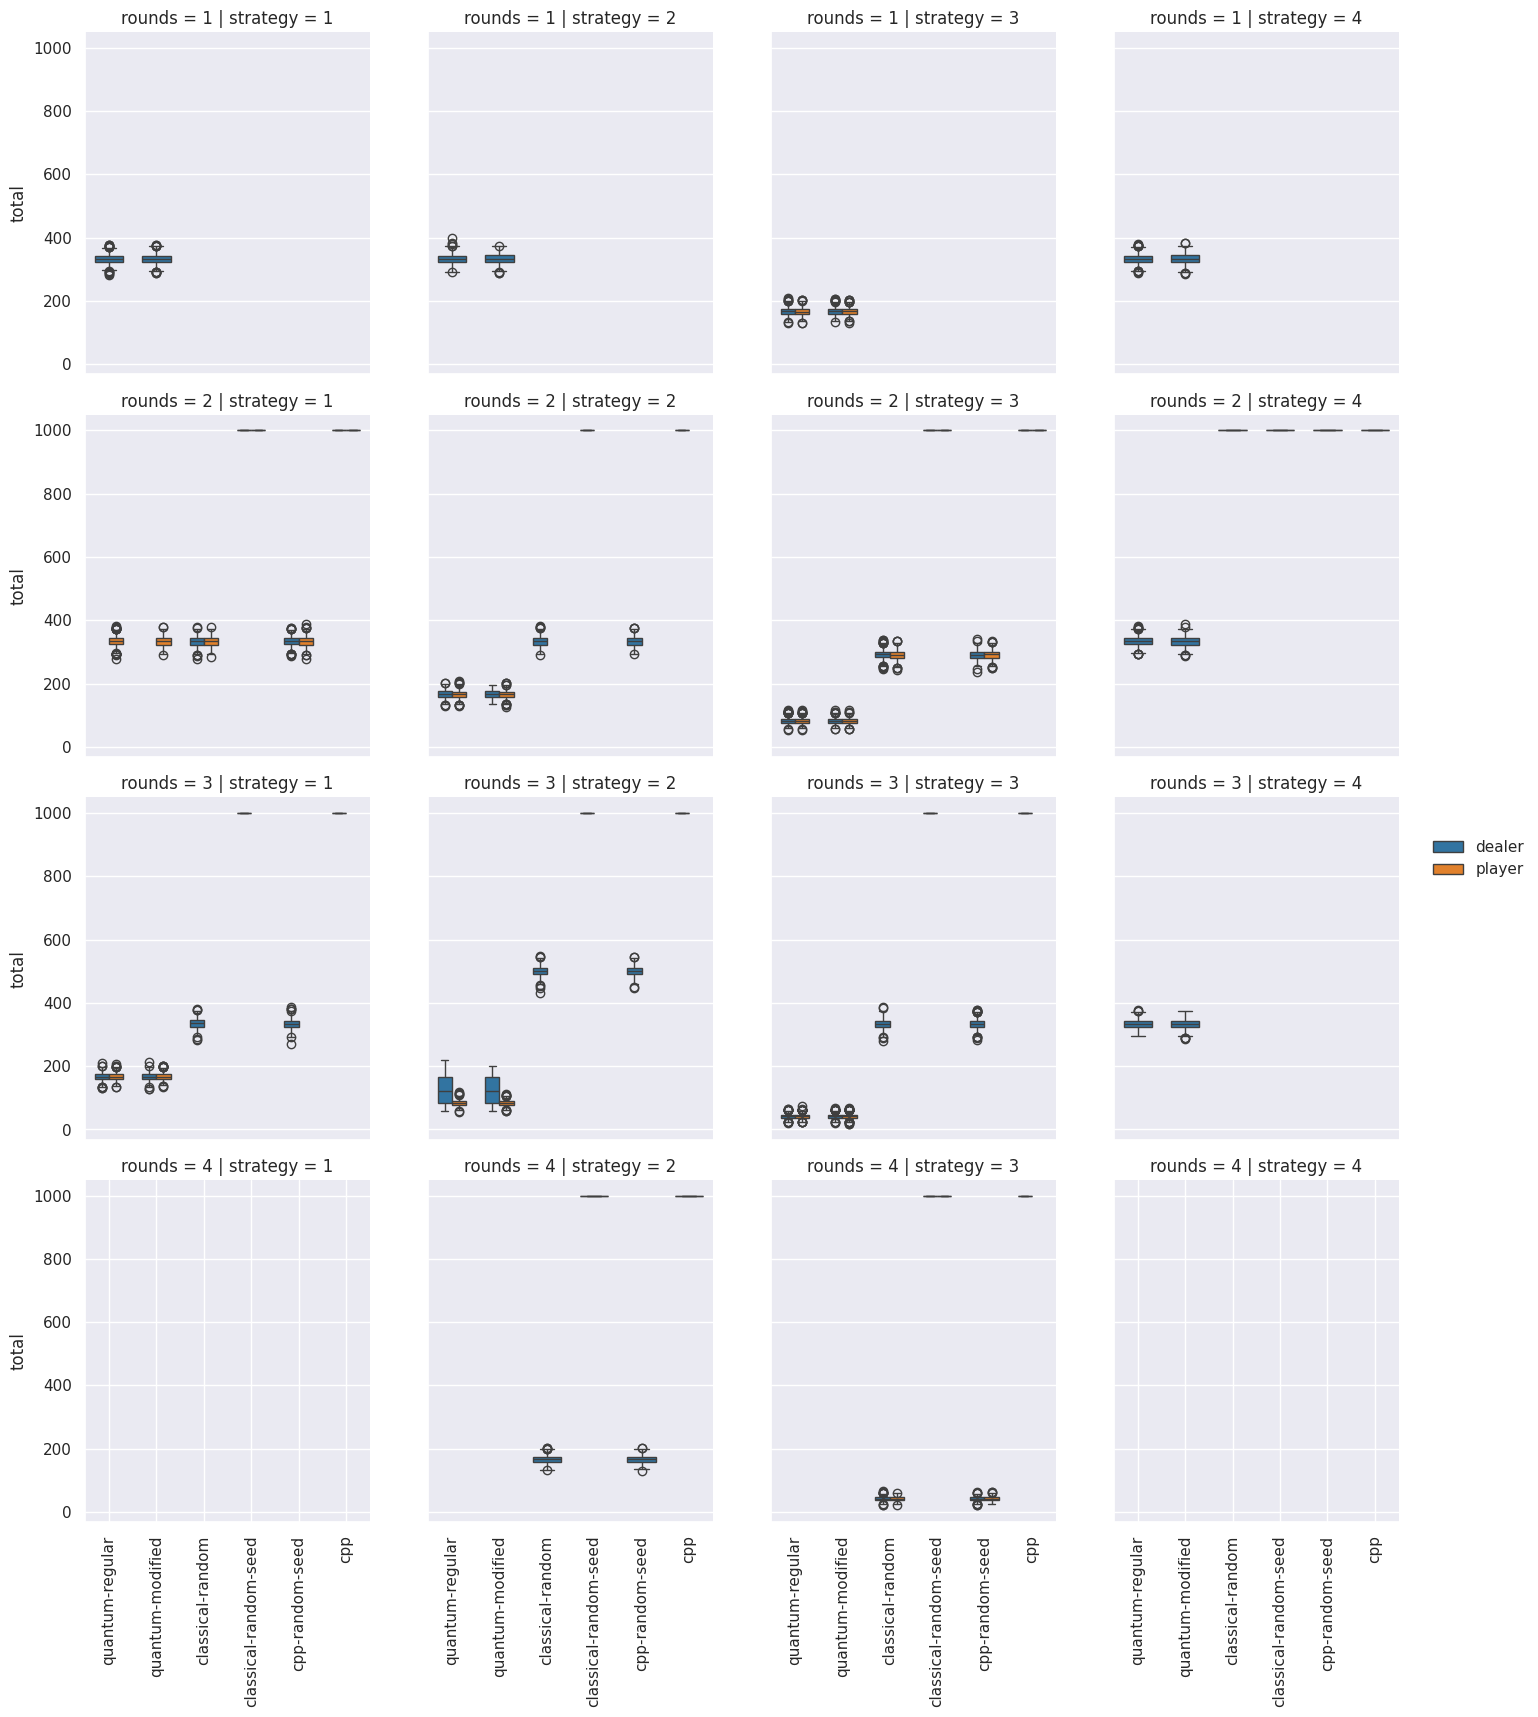

In [5]:
sns.set_context("paper")
sns.set_theme(style="darkgrid")
g = sns.FacetGrid(data, row="rounds", col="strategy", height=4, aspect=.9)
g.map_dataframe(sns.boxplot, y="total", hue="winner", x="label", width=0.6, dodge=True, palette="tab10")
g.add_legend()
g.tight_layout()
g.set_xlabels("")
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=90)
g.savefig(os.path.join(TARGET_ASSETS_FOLDER, "comparing-results.png"))
plt.show()

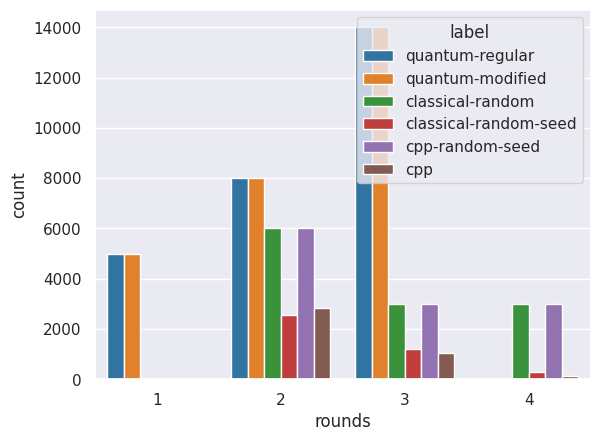

In [6]:
sns.set_theme(style="darkgrid")
sns.countplot(data=data, x="rounds", hue="label", palette="tab10")
plt.savefig(os.path.join(TARGET_ASSETS_FOLDER, "total_rounds.png"), bbox_inches="tight")
plt.show()


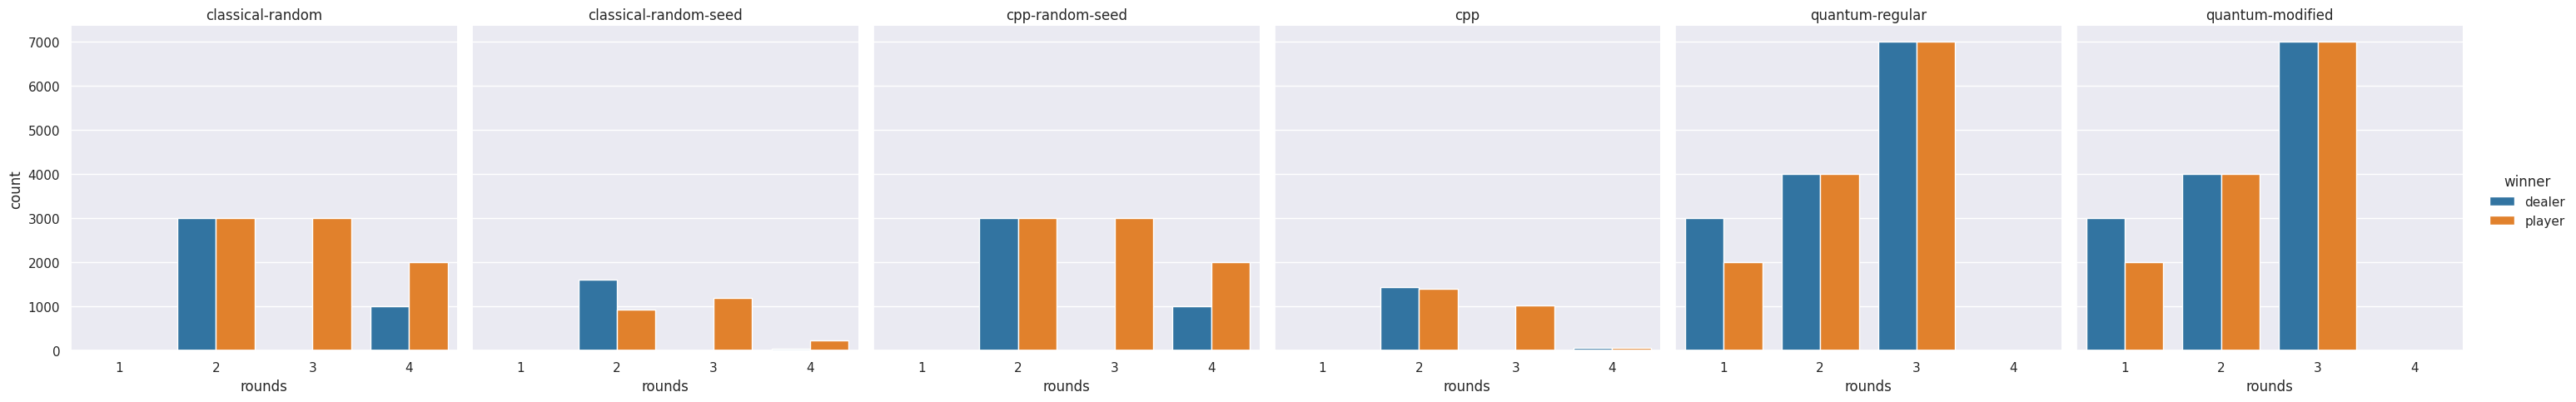

In [7]:
sns.set_theme(style="darkgrid")
g = sns.catplot(data=data, x="rounds", hue="winner", palette="tab10", col="label", kind="count")
g.set_titles(col_template="{col_name}")
plt.savefig(os.path.join(TARGET_ASSETS_FOLDER, "total_rounds_per_version.png"), bbox_inches="tight")
plt.show()


## Analysis for each version

To Understand how the players' winnings are distributed


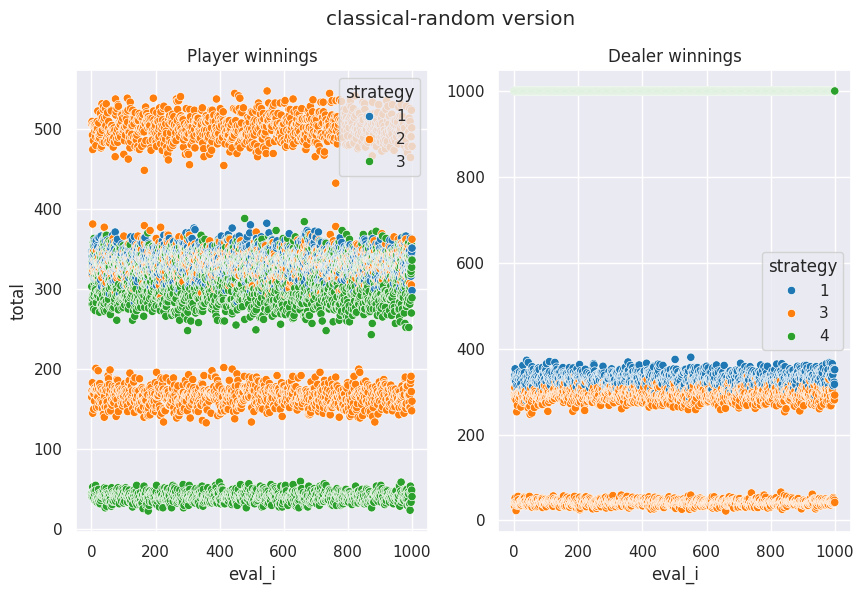

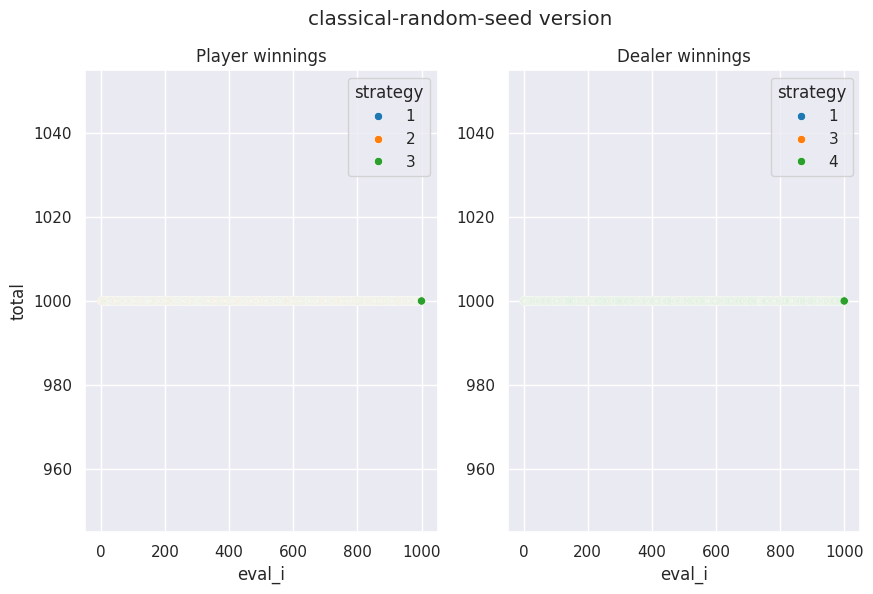

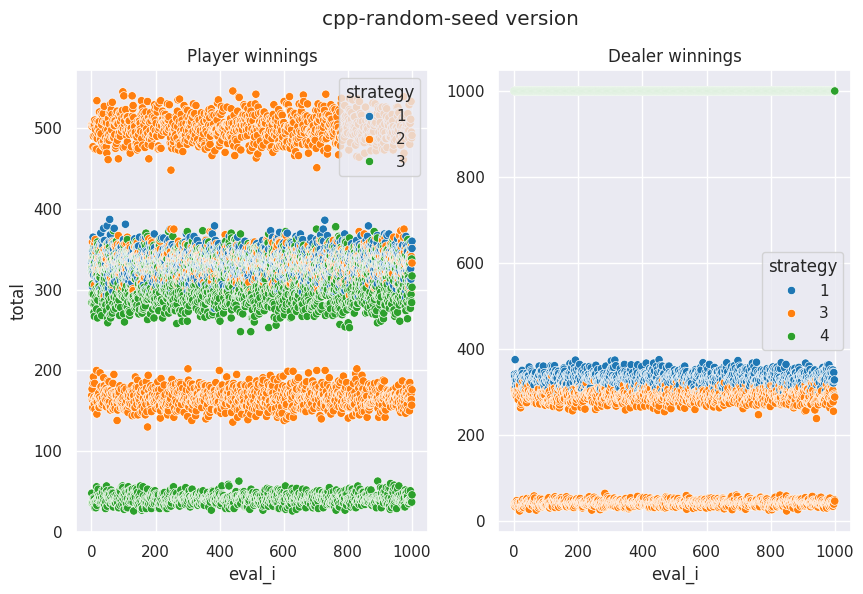

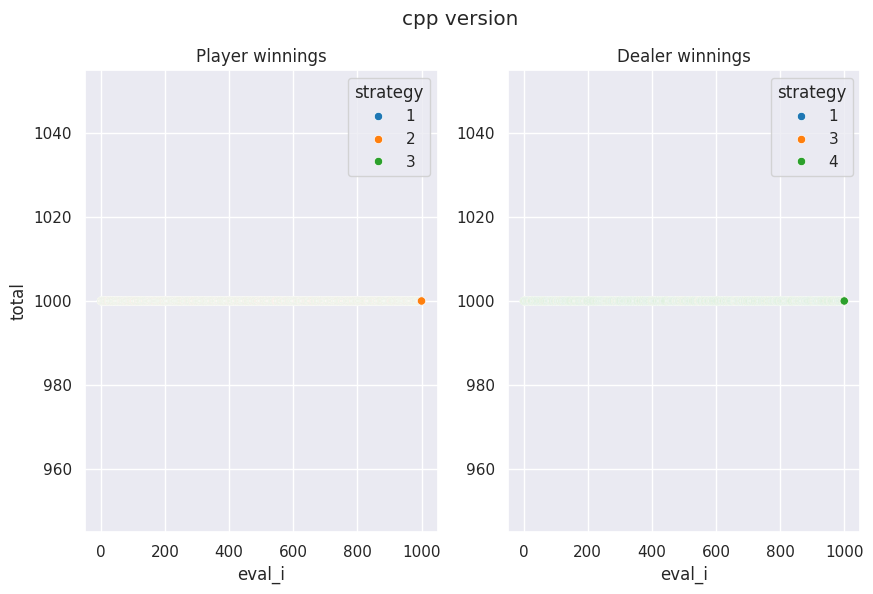

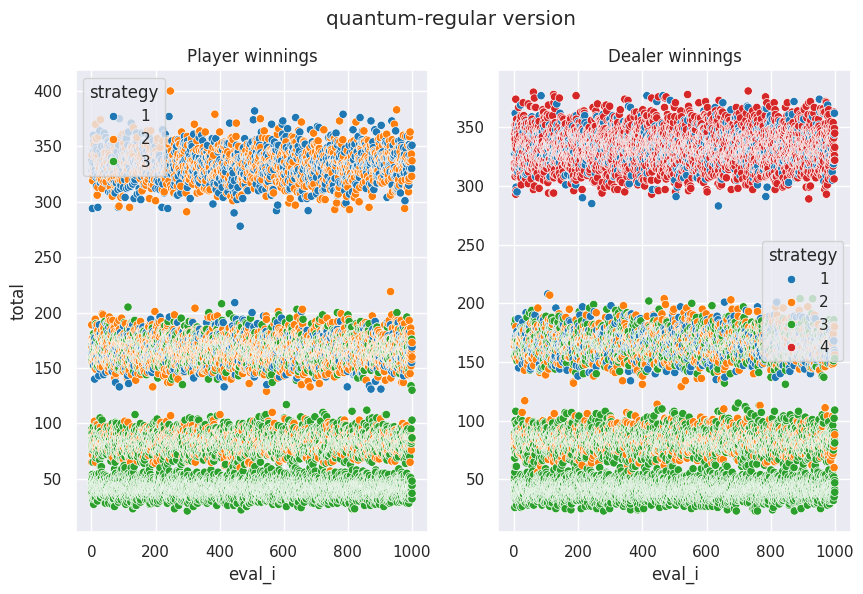

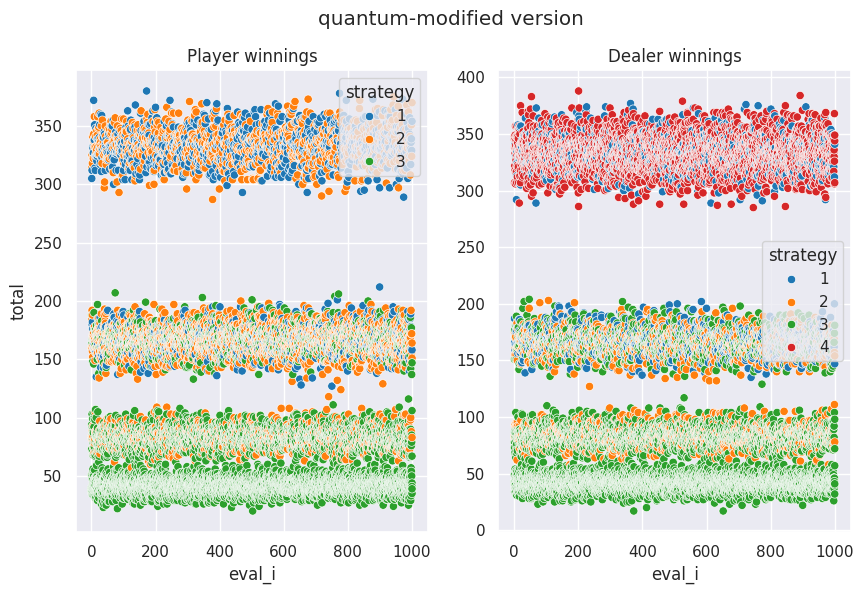

In [8]:
print("To Understand how the players' winnings are distributed")
for version in labels:
    subset = data[data["label"] == version]
    dealer_winnings = subset[subset["winner"] == "dealer"]
    player_winnings = subset[subset["winner"] == "player"]

    sns.set_theme(style="darkgrid")
    fig,ax = plt.subplots(1,2, figsize=(10,6))

    sns.scatterplot(data=player_winnings, x="eval_i", y="total", ax=ax[0], palette="tab10", hue="strategy")
    ax[0].set_title("Player winnings")

    sns.scatterplot(data=dealer_winnings, x="eval_i", y="total", ax=ax[1], palette="tab10", hue="strategy")
    ax[1].set_title("Dealer winnings")
    ax[1].set_ylabel("")

    fig.suptitle(f"{version} version")
    plt.savefig(os.path.join(TARGET_ASSETS_FOLDER, f"{version}-distribution-winnings-per-eval.png"), bbox_inches="tight")

    plt.show()

To Understand how many rounds each strategy takes to win


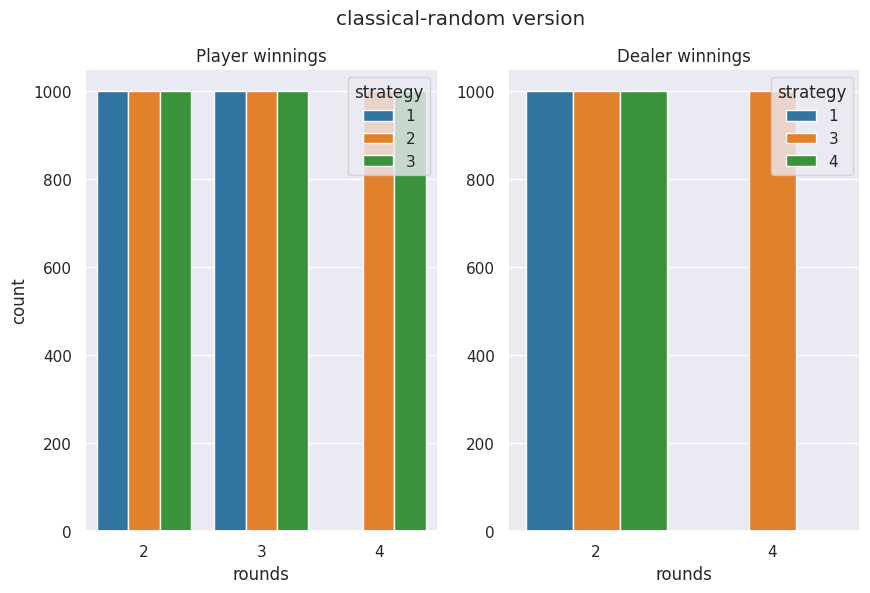

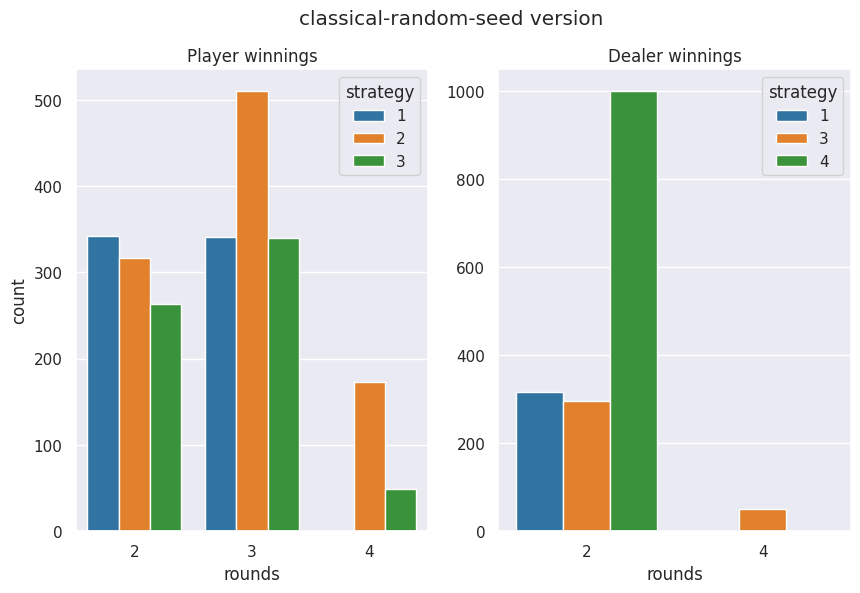

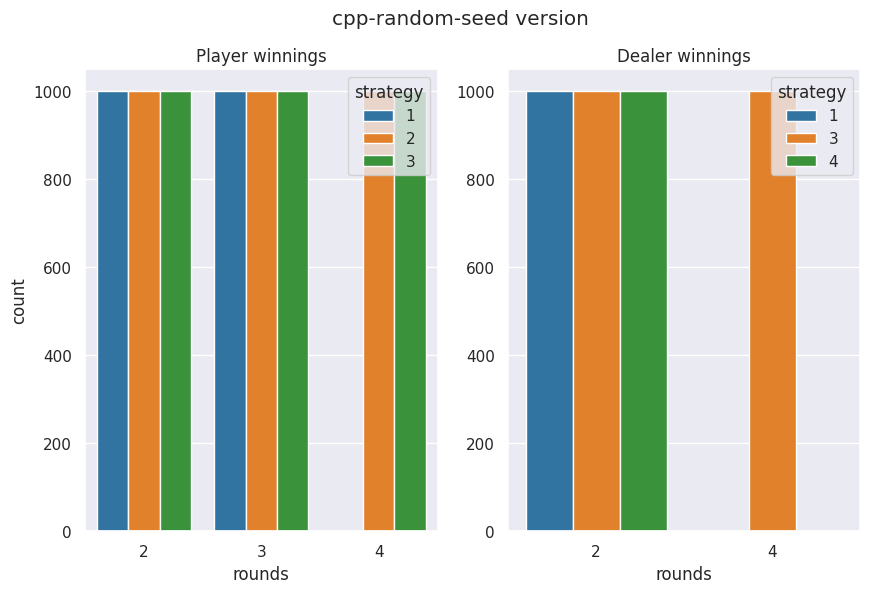

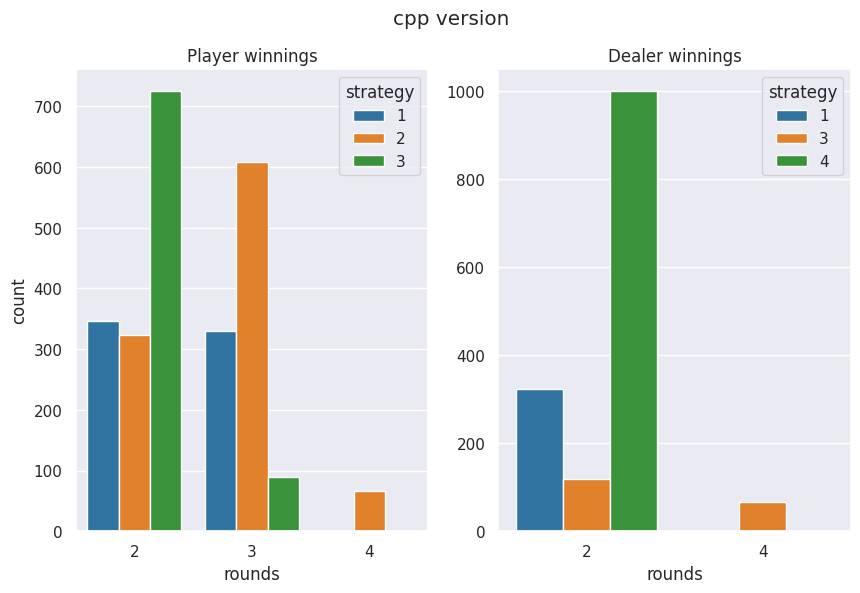

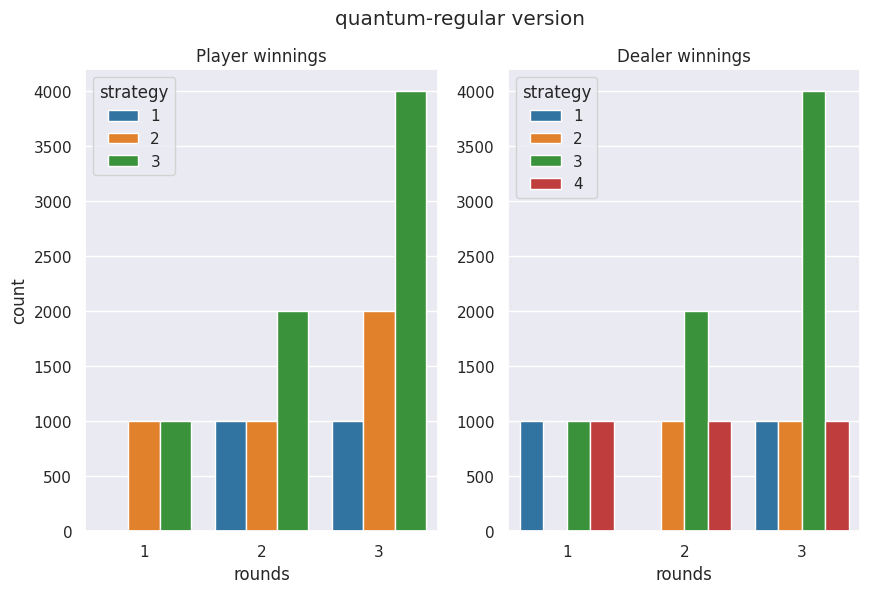

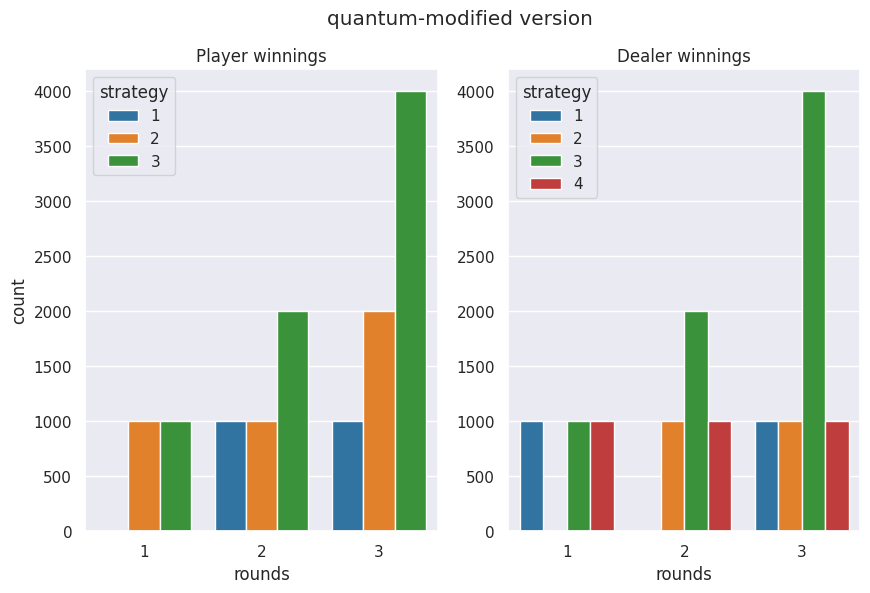

In [9]:
print("To Understand how many rounds each strategy takes to win")
for version in labels:
    subset = data[data["label"] == version]
    dealer_winnings = subset[subset["winner"] == "dealer"]
    player_winnings = subset[subset["winner"] == "player"]

    sns.set_theme(style="darkgrid")
    fig,ax = plt.subplots(1,2, figsize=(10,6))

    sns.countplot(data=player_winnings, x="rounds", ax=ax[0], palette="tab10", hue="strategy")
    ax[0].set_title("Player winnings")

    sns.countplot(data=dealer_winnings, x="rounds", ax=ax[1], palette="tab10", hue="strategy")
    ax[1].set_title("Dealer winnings")
    ax[1].set_ylabel("")

    fig.suptitle(f"{version} version")
    plt.savefig(os.path.join(TARGET_ASSETS_FOLDER, f"{version}-rounds-per-strategy.png"), bbox_inches="tight")

    plt.show()

To See how many times a version is better than the other based on how many wins


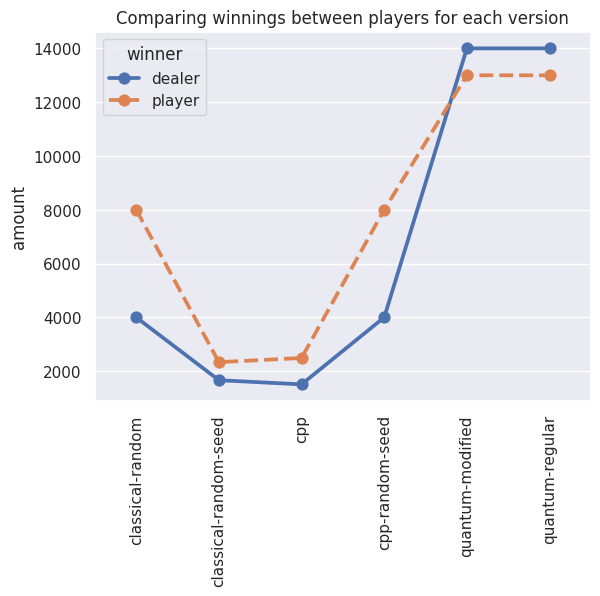

In [10]:
print("To See how many times a version is better than the other based on how many wins")

data["amount"] = 1
amount_of_winnings = data.groupby(["winner", "label"]).sum()["amount"].reset_index()

sns.set_theme(style="darkgrid")
plt.title("Comparing winnings between players for each version")
sns.pointplot(data=amount_of_winnings, x="label", y="amount", hue="winner", linestyles=["-", "--"],)
plt.xlabel("")
plt.xticks(rotation=90)
plt.savefig(os.path.join(TARGET_ASSETS_FOLDER, "winnings-per-version.png"), bbox_inches="tight")
plt.show()